# 3d — Logistic Regression (Fatal vs Non‑Fatal)

This notebook trains an interpretable **logistic regression** model to predict whether an incident is **fatal** (`1`) or **non‑fatal** (`0`).


In [1]:
# Install required packages
%pip install -q pandas numpy scikit-learn seaborn matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Imports
import numpy as np
import pandas as pd

from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score,
    confusion_matrix, roc_curve, precision_recall_curve, auc
)

import matplotlib.pyplot as plt
import seaborn as sns

## Load data

Update `DATA_PATH` to point to your prepared dataset.

In [3]:
DATA_PATH = Path("../../data/final/data_post_eda.csv")

df = pd.read_csv(DATA_PATH)
print("Loaded:", df.shape)
df.head()

Loaded: (211, 59)


,id,date_published,accident_datetime,accident_severity,total_injured,city,street,accident_time_category,driver_under_18,driver_18_to_24,...,temperature_mean,precipitation_sum,windspeed_max,is_raining,traffic_level,is_fatal,accident_year,accident_month,accident_day_of_week,accident_hour
0,article_495320.0,30/09/2025,2024-03-19 00:00:00,not injured,0,birkirkara,naxxar road,night,False,False,...,16.0,0.0,20.9,False,LOW,0,2024,3,1,0
1,article_495942.0,06/10/2025,2024-09-23 00:00:00,not injured,0,san pawl il bahar,triq censu tabone,night,False,False,...,23.5,7.3,22.7,True,LOW,0,2024,9,0,0
2,article_4208.0,07/12/2024,2024-12-04 17:00:00,not injured,0,st julian,regional road,afternoon,False,False,...,17.6,1.1,21.9,True,MODERATE,0,2024,12,2,17
3,release_83,11/12/2024,2024-12-11 11:15:00,grievious,1,naxxar,triq ernle bradford,morning,False,False,...,14.9,0.0,9.9,False,LOW,0,2024,12,2,11
4,article_4024.0,17/12/2024,2024-12-11 17:00:00,fatal,1,san pawl il bahar,xemxija bypass,afternoon,False,False,...,15.4,0.0,9.9,False,LOW,1,2024,12,2,17


## Feature engineering

We create a few simple binary flags to reduce granularity and keep the model interpretable.

In [4]:
# Normalize severity label casing (robust to extra spaces / casing)
severity = df["accident_severity"].astype(str).str.strip().str.lower()

# Binary target: fatal vs non-fatal
df["is_fatal"] = (severity == "fatal").astype(int)



## Select features


In [5]:
FEATURES = [
    # drivers (counts)
    "num_drivers_under_18",
    "num_drivers_18_to_24",
    "num_drivers_25_to_49",
    "num_drivers_50_to_64",
    "num_drivers_65_plus",
    "num_drivers_age_unknown",
    "num_drivers_male",
    "num_drivers_female",
    "num_drivers_gender_unknown",

    # vehicles (counts)
    "num_vehicle_unknown",
    "num_vehicle_pedestrian",
    "num_vehicle_bicycle",
    "num_vehicle_motorbike",
    "num_vehicle_car",
    "num_vehicle_van",
    "num_vehicle_bus",


    # calendar / weather / context
    "is_weekend",
    "is_school_holiday_mt",
    "temperature_mean",
    "is_raining",

    # lower-cardinality categoricals
    "accident_time_category",
    "region"
  
]

TARGET = "is_fatal"

final_df = df[FEATURES + [TARGET]].copy()

# Ensure booleans are numeric 0/1 where relevant
for col in ["is_weekend", "is_school_holiday_mt", "is_high_speed_road", "is_dark", "is_peak", "is_vulnerable_road_user", "is_heavy_vehicle"]:
    if col in final_df.columns:
        final_df[col] = final_df[col].astype(int)

print("Modeling DF:", final_df.shape)
final_df.head()

Modeling DF: (211, 23)


,num_drivers_under_18,num_drivers_18_to_24,num_drivers_25_to_49,num_drivers_50_to_64,num_drivers_65_plus,num_drivers_age_unknown,num_drivers_male,num_drivers_female,num_drivers_gender_unknown,num_vehicle_unknown,...,num_vehicle_car,num_vehicle_van,num_vehicle_bus,is_weekend,is_school_holiday_mt,temperature_mean,is_raining,accident_time_category,region,is_fatal
0,0,0,0,0,0,1,0,1,0,0,...,1,0,0,0,0,16.0,False,night,Central,0
1,0,0,1,0,0,1,2,0,0,0,...,1,0,0,0,0,23.5,True,night,Northern,0
2,0,0,0,0,1,1,1,0,1,0,...,2,0,0,0,0,17.6,True,afternoon,Northern,0
3,0,0,1,0,0,0,0,1,0,0,...,1,0,0,0,0,14.9,False,morning,Northern,0
4,0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,15.4,False,afternoon,Northern,1


## Train/test split

Stratified split preserves the (rare) fatal rate in train and test.

In [6]:
X = final_df.drop(columns=[TARGET])
y = final_df[TARGET].astype(int)

RANDOM_STATE = 42
TEST_SIZE = 0.20
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)

print("Train:", X_train.shape, "Fatal rate:", y_train.mean())
print("Test :", X_test.shape,  "Fatal rate:", y_test.mean())

Train: (168, 22) Fatal rate: 0.13095238095238096
Test : (43, 22) Fatal rate: 0.13953488372093023


## Preprocessing + model pipeline

We keep it simple: impute, scale/encode, then a single logistic regression fit.

## Train + evaluate (basic)

In [ ]:
# Define feature types
numeric_features = [
    "num_drivers_under_18", "num_drivers_18_to_24", "num_drivers_25_to_49",
    "num_drivers_50_to_64", "num_drivers_65_plus", "num_drivers_age_unknown",
    "num_drivers_male", "num_drivers_female", "num_drivers_gender_unknown",
    "num_vehicle_unknown", "num_vehicle_pedestrian", "num_vehicle_bicycle",
    "num_vehicle_motorbike", "num_vehicle_car", "num_vehicle_van", "num_vehicle_bus",
    "is_weekend", "is_school_holiday_mt", "temperature_mean", "is_raining"
]

categorical_features = ["accident_time_category", "region"]

# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("impute", SimpleImputer(strategy="median")),
            ("scale", StandardScaler())
        ]), numeric_features),
        ("cat", Pipeline([
            ("impute", SimpleImputer(strategy="constant", fill_value="unknown")),
            ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
        ]), categorical_features)
    ]
)

# Create full pipeline with logistic regression
clf = Pipeline([
    ("preprocess", preprocessor),
    ("model", LogisticRegression(max_iter=1000, random_state=RANDOM_STATE))
])

In [7]:
# Fit basic logistic regression
clf.fit(X_train, y_train)

# Test-set probabilities and predictions (default threshold 0.5)
test_proba = clf.predict_proba(X_test)[:, 1]
y_pred = clf.predict(X_test)

metrics = {
    "accuracy": accuracy_score(y_test, y_pred),
    "precision": precision_score(y_test, y_pred, zero_division=0),
    "recall": recall_score(y_test, y_pred, zero_division=0),
    "f1": f1_score(y_test, y_pred, zero_division=0),
    "roc_auc": roc_auc_score(y_test, test_proba),
    "pr_auc": average_precision_score(y_test, test_proba),
}

pd.DataFrame(metrics, index=["logreg_default"]).round(3)

NameError: name 'clf' is not defined

In [ ]:
# Tuned threshold (pick the threshold that maximizes F1 on the test PR curve)
prec, rec, thr = precision_recall_curve(y_test, test_proba)
prec, rec = prec[:-1], rec[:-1]  # align lengths with thresholds
f1_scores = 2 * prec * rec / (prec + rec + 1e-12)
best_idx = int(np.nanargmax(f1_scores)) if len(f1_scores) else 0
tuned_threshold = float(thr[best_idx]) if len(thr) else 0.5

tuned_pred = (test_proba >= tuned_threshold).astype(int)
tuned_metrics = {
    "accuracy": accuracy_score(y_test, tuned_pred),
    "precision": precision_score(y_test, tuned_pred, zero_division=0),
    "recall": recall_score(y_test, tuned_pred, zero_division=0),
    "f1": f1_score(y_test, tuned_pred, zero_division=0),
    "roc_auc": roc_auc_score(y_test, test_proba),
    "pr_auc": average_precision_score(y_test, test_proba),
}

pd.DataFrame([metrics, tuned_metrics], index=["threshold=0.5", f"tuned={tuned_threshold:.3f}"]).round(3)

,accuracy,precision,recall,f1,roc_auc,pr_auc
threshold=0.5,0.814,0.000,0.0,0.000,0.635,0.193
tuned=0.100,0.605,0.261,1.0,0.414,0.635,0.193


## Plots (ROC, PR, confusion matrix)

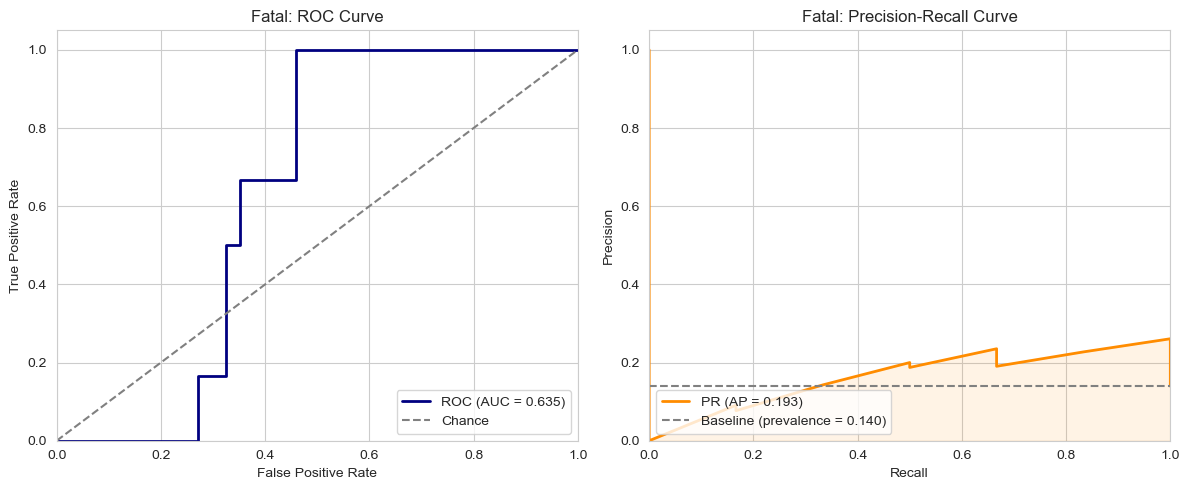

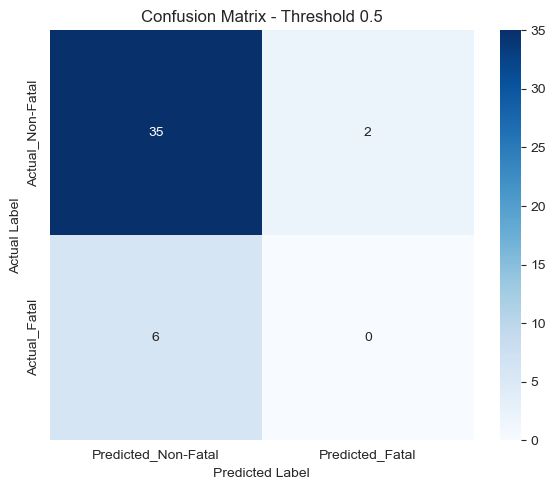

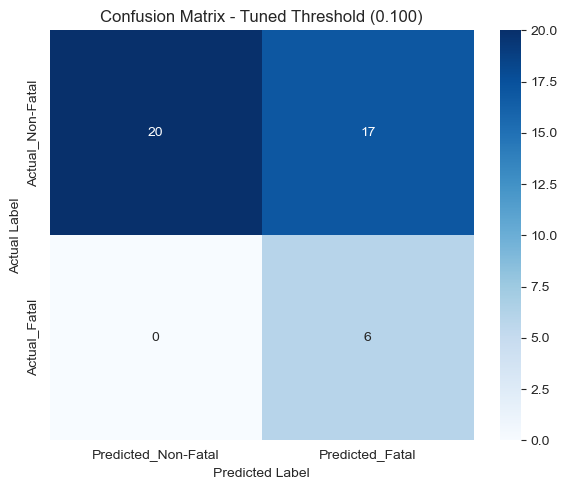

In [ ]:
# ROC and PR curves + confusion matrix for default and tuned thresholds
sns.set_style("whitegrid")
fpr, tpr, _ = roc_curve(y_test, test_proba)
roc_auc = auc(fpr, tpr)

prec, rec, _ = precision_recall_curve(y_test, test_proba)
pr_ap = average_precision_score(y_test, test_proba)
base_rate = float(y_test.mean())

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# ROC
axes[0].plot(fpr, tpr, color="navy", lw=2, label=f"ROC (AUC = {roc_auc:.3f})")
axes[0].plot([0, 1], [0, 1], "--", color="gray", label="Chance")
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].set_xlabel("False Positive Rate")
axes[0].set_ylabel("True Positive Rate")
axes[0].set_title("Fatal: ROC Curve")
axes[0].legend(loc="lower right")

# Precision-Recall
axes[1].plot(rec, prec, color="darkorange", lw=2, label=f"PR (AP = {pr_ap:.3f})")
axes[1].fill_between(rec, prec, alpha=0.1, color="darkorange")
axes[1].axhline(y=base_rate, color="gray", linestyle="--", label=f"Baseline (prevalence = {base_rate:.3f})")
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel("Recall")
axes[1].set_ylabel("Precision")
axes[1].set_title("Fatal: Precision-Recall Curve")
axes[1].legend(loc="lower left")

plt.tight_layout()
plt.show()

# Confusion matrix at default threshold
cm_default = confusion_matrix(y_test, y_pred)
cm_matrix_default = pd.DataFrame(
    cm_default,
    index=['Actual_Non-Fatal','Actual_Fatal'],
    columns=['Predicted_Non-Fatal','Predicted_Fatal']
 )

fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(cm_matrix_default, annot=True, fmt='d', cmap='Blues', ax=ax)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix - Threshold 0.5')
plt.tight_layout()
plt.show()

# Confusion matrix at tuned threshold
cm_tuned = confusion_matrix(y_test, tuned_pred)
cm_matrix_tuned = pd.DataFrame(
    cm_tuned,
    index=['Actual_Non-Fatal','Actual_Fatal'],
    columns=['Predicted_Non-Fatal','Predicted_Fatal']
 )

fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(cm_matrix_tuned, annot=True, fmt='d', cmap='Blues', ax=ax)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title(f'Confusion Matrix - Tuned Threshold ({tuned_threshold:.3f})')
plt.tight_layout()
plt.show()

## Coefficients (interpretability)

Coefficients are in **log‑odds**. Positive values increase the odds of `Fatal=1`, negative values decrease them.

,feature,coef
20,accident_time_category_early_morning,-1.111030
26,region_Gozo,-0.826396
5,num_drivers_age_unknown,-0.823950
23,accident_time_category_morning,-0.781962
27,region_Northern,-0.581182
24,accident_time_category_night,-0.340748
28,region_South Eastern,-0.287574
4,num_drivers_65_plus,-0.224008
12,num_vehicle_motorbike,-0.200412
6,num_drivers_male,-0.183640


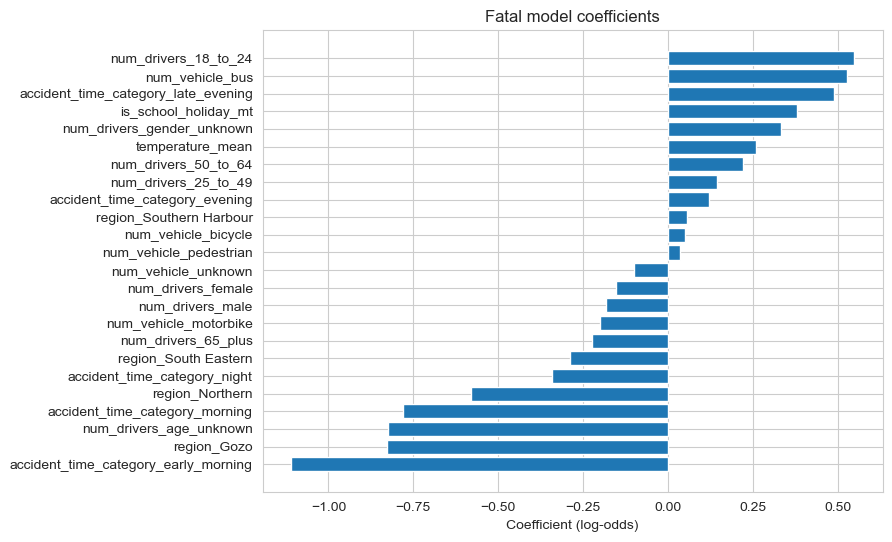

In [ ]:
def get_feature_names(preprocessor: ColumnTransformer):
    num = preprocessor.named_transformers_["num"]
    cat = preprocessor.named_transformers_["cat"]

    num_features = numeric_features

    # One-hot feature names
    ohe = cat.named_steps["onehot"]
    cat_features = categorical_features
    ohe_features = ohe.get_feature_names_out(cat_features).tolist()

    return num_features + ohe_features

def show_top_coefficients(trained_pipeline: Pipeline, top_k=12, title="Top coefficients"):
    pre = trained_pipeline.named_steps["preprocess"]
    model = trained_pipeline.named_steps["model"]

    feature_names = get_feature_names(pre)
    coef = model.coef_.ravel()

    coef_df = pd.DataFrame({"feature": feature_names, "coef": coef}).sort_values("coef")

    top = pd.concat([coef_df.head(top_k), coef_df.tail(top_k)])
    display(top)

    plt.figure(figsize=(8, 6))
    plt.barh(top["feature"], top["coef"])
    plt.title(title)
    plt.xlabel("Coefficient (log-odds)")
    plt.show()

show_top_coefficients(clf, title="Fatal model coefficients")

## Conclusion

- The model is intentionally simple and interpretable.
- For rare fatal cases, **PR‑AUC** and **recall** are more informative than accuracy.
- Report results at both a **default threshold (0.5)** and a  **tuned operating point**.